In [6]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
!pip install optuna
!pip install mlflow
import optuna
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')
#plt.style.use('seaborn')

In [7]:
df_G23AI2132 = pd.read_csv('/content/sample_data/indian_liver_patientmissing.csv')

numeric_cols = ['Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
                'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens']

for col in numeric_cols:
    df_G23AI2132[col] = pd.to_numeric(df_G23AI2132[col], errors='coerce')

print("Dataset Shape:", df_G23AI2132.shape)
df_G23AI2132.head()

Dataset Shape: (583, 11)


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,LiverPateientOrNot 1meansNO
0,65,Female,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1


In [8]:
numeric_cols = df_G23AI2132.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_G23AI2132.select_dtypes(include=['object']).columns

print("Basic Stats for Numeric Features:")
print(df_G23AI2132[numeric_cols].describe())

print("\nMissing Values:")
print(df_G23AI2132.isnull().sum())

print("\nValue Counts for Gender:")
print(df_G23AI2132['Gender'].value_counts())

print("\nLiver Patient Distribution:")
print(df_G23AI2132['LiverPateientOrNot 1meansNO'].value_counts())

Basic Stats for Numeric Features:
              Age  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
count  583.000000       580.000000        579.000000            582.000000   
mean    44.746141         3.303448          1.487392            290.591065   
std     16.189833         6.222844          2.816363            243.146707   
min      4.000000         0.400000          0.100000             63.000000   
25%     33.000000         0.800000          0.200000            175.250000   
50%     45.000000         1.000000          0.300000            208.000000   
75%     58.000000         2.600000          1.300000            298.000000   
max     90.000000        75.000000         19.700000           2110.000000   

       Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
count                580.000000                  580.000000      581.000000   
mean                  80.387931                  109.003448        6.489329   
std                  182.9

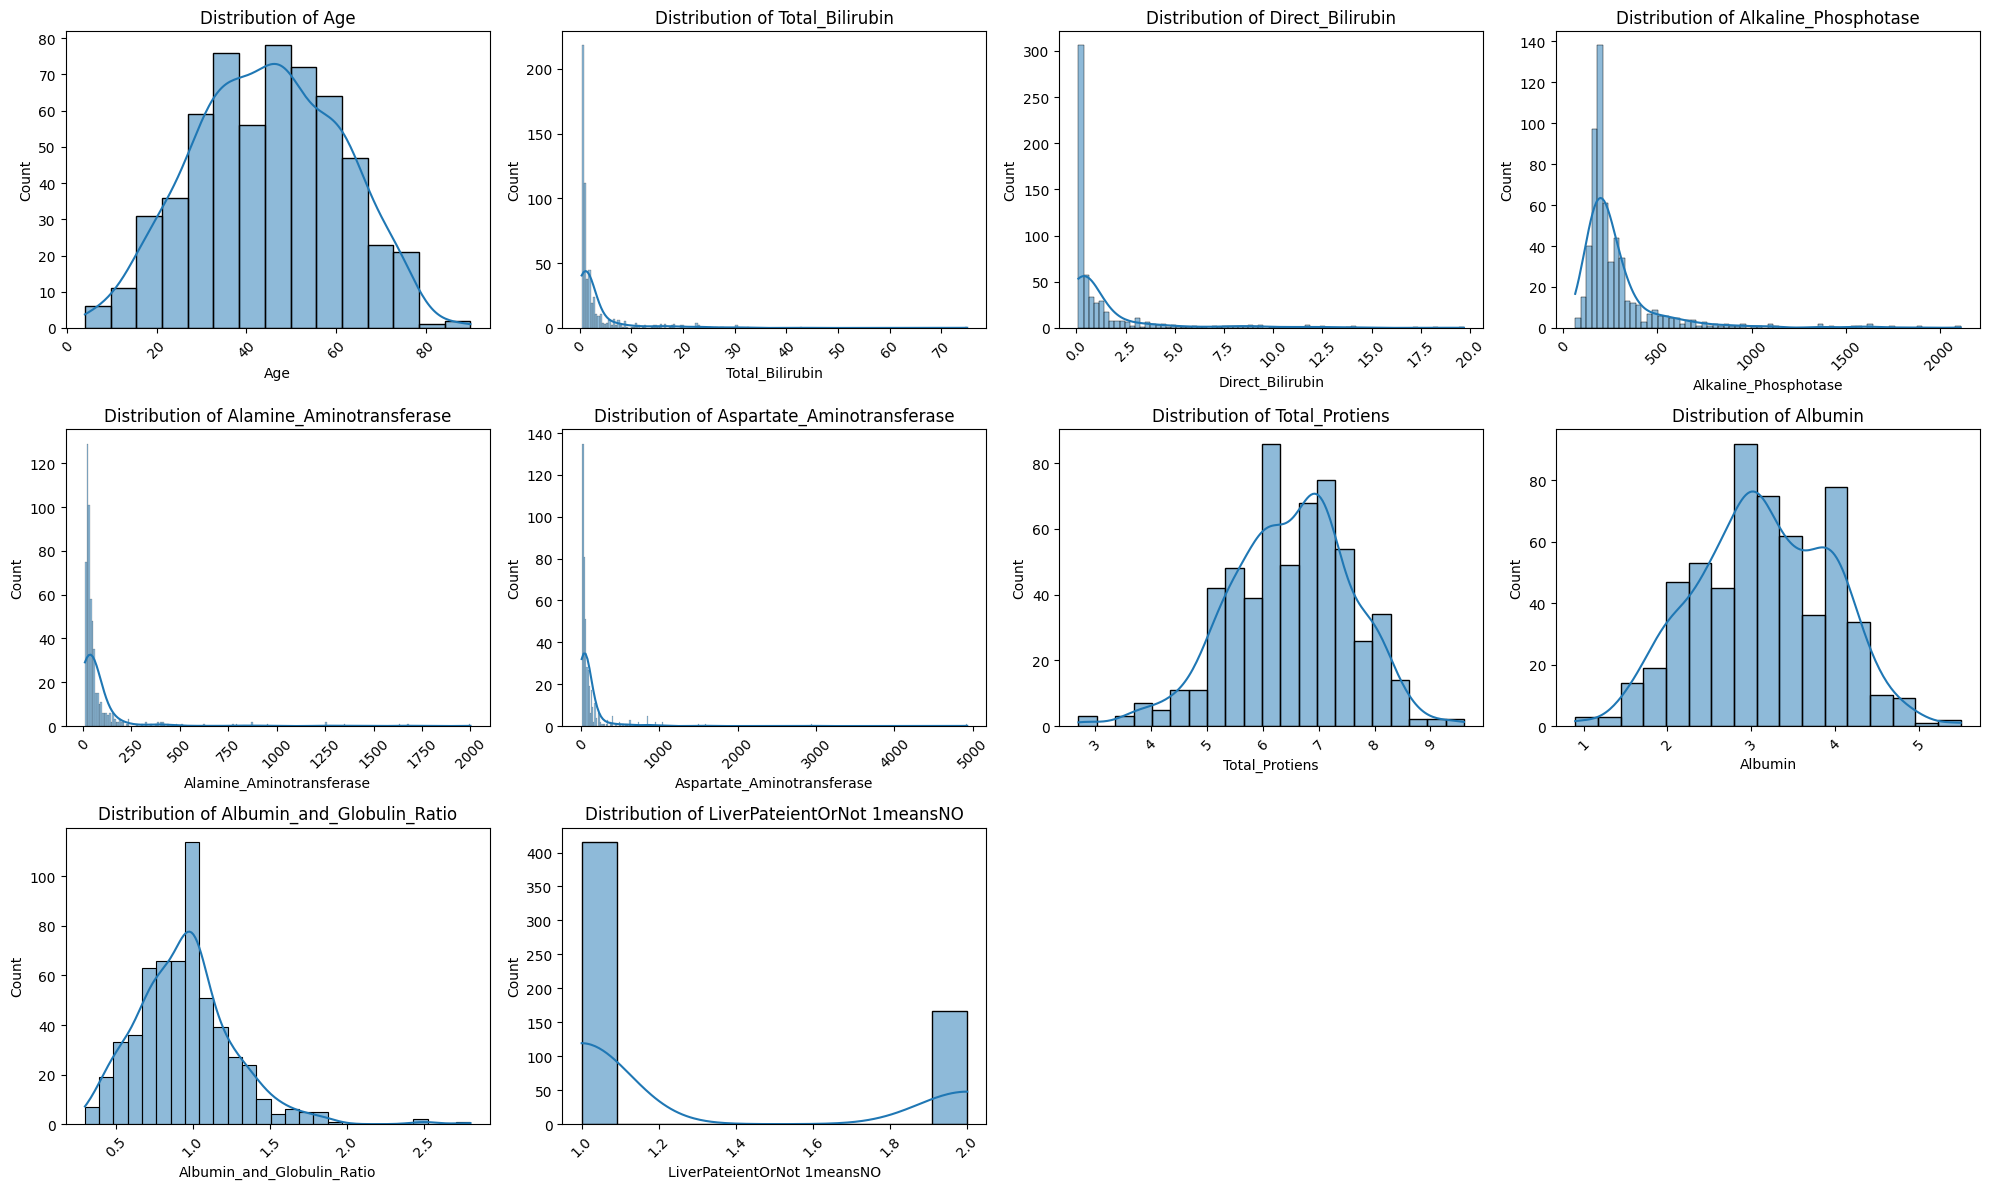

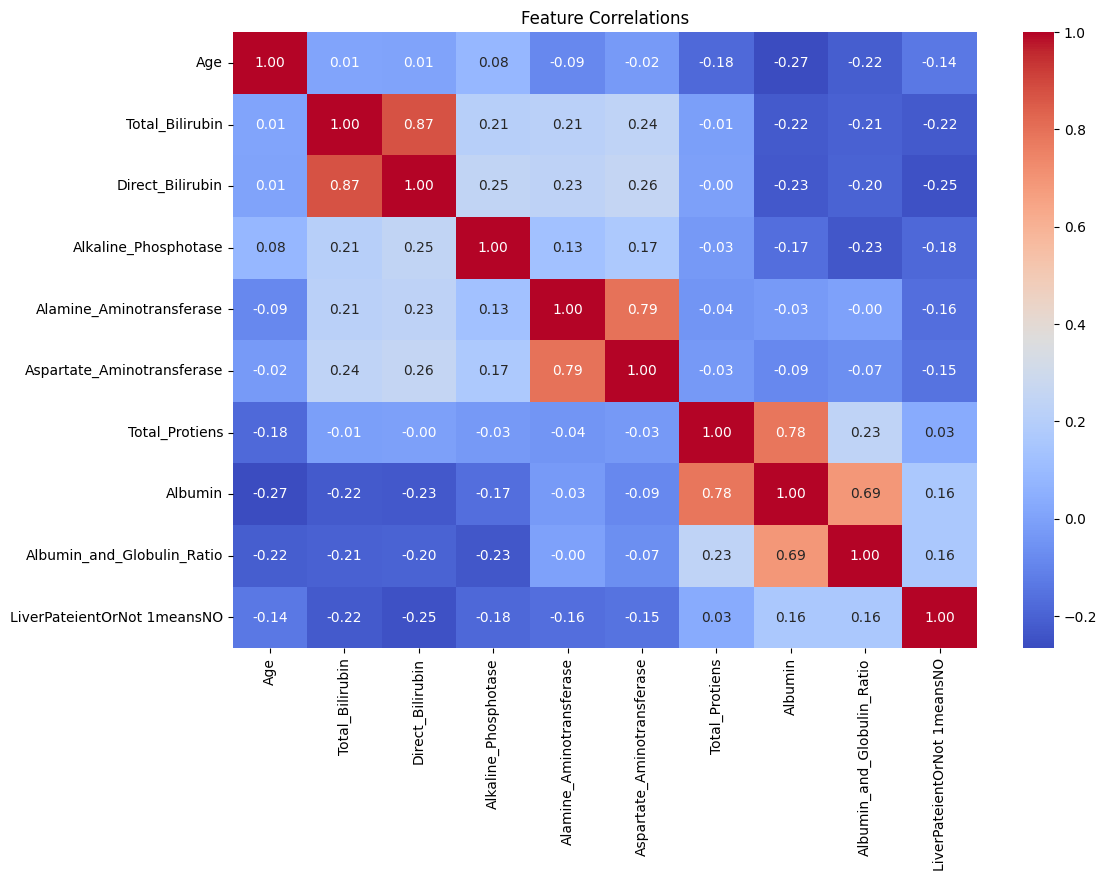

In [10]:
plt.figure(figsize=(20, 12))

for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, idx)
    sns.histplot(data=df_G23AI2132, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df_G23AI2132[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlations")
plt.show()

In [11]:
df_processed = df_G23AI2132.copy()
df_processed['Gender'] = LabelEncoder().fit_transform(df_processed['Gender'])
df_processed = df_processed.fillna(df_processed.median())

X = df_processed.drop('LiverPateientOrNot 1meansNO', axis=1)
y = df_processed['LiverPateientOrNot 1meansNO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

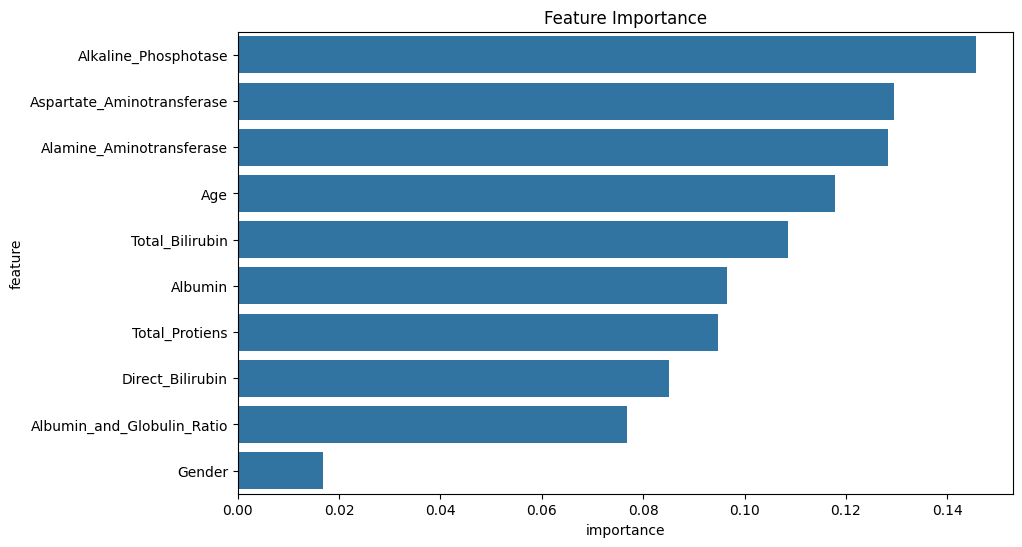

In [12]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': forest.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()

In [13]:
def optimize_tree(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }

    model = DecisionTreeClassifier(**params, random_state=42)
    model.fit(X_train_scaled, y_train)
    return accuracy_score(y_test, model.predict(X_test_scaled))

study_tree = optuna.create_study(direction='maximize')
study_tree.optimize(optimize_tree, n_trials=50)

print("Best Decision Tree Parameters:", study_tree.best_params)
print("Best Score:", study_tree.best_value)

[I 2024-12-07 16:05:16,432] A new study created in memory with name: no-name-0c37a5e3-2da3-4c06-a247-d08798e4b417
[I 2024-12-07 16:05:16,459] Trial 0 finished with value: 0.7350427350427351 and parameters: {'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7350427350427351.
[I 2024-12-07 16:05:16,473] Trial 1 finished with value: 0.6666666666666666 and parameters: {'max_depth': 15, 'min_samples_split': 18, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7350427350427351.
[I 2024-12-07 16:05:16,487] Trial 2 finished with value: 0.6923076923076923 and parameters: {'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7350427350427351.
[I 2024-12-07 16:05:16,500] Trial 3 finished with value: 0.6752136752136753 and parameters: {'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7350427350427351.
[I 2024-12-07 16:05:16,513] Trial 4 finished with value: 0

Best Decision Tree Parameters: {'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 4}
Best Score: 0.7606837606837606


In [14]:
def optimize_forest(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }

    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train_scaled, y_train)
    return accuracy_score(y_test, model.predict(X_test_scaled))

study_forest = optuna.create_study(direction='maximize')
study_forest.optimize(optimize_forest, n_trials=50)

print("Best Random Forest Parameters:", study_forest.best_params)
print("Best Score:", study_forest.best_value)

[I 2024-12-07 16:05:35,449] A new study created in memory with name: no-name-1579908a-343c-45b2-bdb2-2908f30ac282
[I 2024-12-07 16:05:36,357] Trial 0 finished with value: 0.717948717948718 and parameters: {'n_estimators': 247, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.717948717948718.
[I 2024-12-07 16:05:36,668] Trial 1 finished with value: 0.7435897435897436 and parameters: {'n_estimators': 85, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7435897435897436.
[I 2024-12-07 16:05:37,019] Trial 2 finished with value: 0.7008547008547008 and parameters: {'n_estimators': 101, 'max_depth': 15, 'min_samples_split': 12, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7435897435897436.
[I 2024-12-07 16:05:37,926] Trial 3 finished with value: 0.717948717948718 and parameters: {'n_estimators': 196, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0

Best Random Forest Parameters: {'n_estimators': 128, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 1}
Best Score: 0.7777777777777778


In [15]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

models = {
    'Decision Tree': DecisionTreeClassifier(**study_tree.best_params),
    'Random Forest': RandomForestClassifier(**study_forest.best_params),
    'Decision Tree with PCA': DecisionTreeClassifier(**study_tree.best_params),
    'Random Forest with PCA': RandomForestClassifier(**study_forest.best_params)
}

results = {}
for name, model in models.items():
    if 'PCA' in name:
        model.fit(X_train_pca, y_train)
        score = model.score(X_test_pca, y_test)
    else:
        model.fit(X_train_scaled, y_train)
        score = model.score(X_test_scaled, y_test)
    results[name] = score

pd.DataFrame({'Model': results.keys(), 'Accuracy': results.values()})

,Model,Accuracy
0,Decision Tree,0.760684
1,Random Forest,0.752137
2,Decision Tree with PCA,0.726496
3,Random Forest with PCA,0.743590


In [16]:
import os
from datetime import datetime

experiment_name = "liver_disease_prediction"
mlflow.set_tracking_uri("sqlite:///mlflow.db")

if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

2024/12/07 16:55:24 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/12/07 16:55:24 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/content/mlruns/1', creation_time=1733590526920, experiment_id='1', last_update_time=1733590526920, lifecycle_stage='active', name='liver_disease_prediction', tags={}>

In [17]:
with mlflow.start_run(run_name=f"decision_tree_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
    dt = DecisionTreeClassifier(**study_tree.best_params, random_state=42)
    dt.fit(X_train_scaled, y_train)
    dt_preds = dt.predict(X_test_scaled)

    dt_accuracy = accuracy_score(y_test, dt_preds)
    dt_cm = confusion_matrix(y_test, dt_preds)

    mlflow.log_params(study_tree.best_params)
    mlflow.log_metric("accuracy", dt_accuracy)

    plt.figure(figsize=(8, 6))
    sns.heatmap(dt_cm, annot=True, fmt='d')
    plt.title("Decision Tree Confusion Matrix")
    plt.savefig("dt_confusion_matrix.png")
    mlflow.log_artifact("dt_confusion_matrix.png")
    plt.close()

    mlflow.sklearn.log_model(dt, "decision_tree_model")

print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")

2024/12/07 16:56:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree Accuracy: 0.7607


In [18]:
with mlflow.start_run(run_name=f"random_forest_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
    rf = RandomForestClassifier(**study_forest.best_params, random_state=42)
    rf.fit(X_train_scaled, y_train)
    rf_preds = rf.predict(X_test_scaled)

    rf_accuracy = accuracy_score(y_test, rf_preds)
    rf_cm = confusion_matrix(y_test, rf_preds)

    mlflow.log_params(study_forest.best_params)
    mlflow.log_metric("accuracy", rf_accuracy)

    plt.figure(figsize=(8, 6))
    sns.heatmap(rf_cm, annot=True, fmt='d')
    plt.title("Random Forest Confusion Matrix")
    plt.savefig("rf_confusion_matrix.png")
    mlflow.log_artifact("rf_confusion_matrix.png")
    plt.close()

    feature_imp_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_imp_df, x='importance', y='feature')
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    mlflow.log_artifact("feature_importance.png")
    plt.close()

    mlflow.sklearn.log_model(rf, "random_forest_model")

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

2024/12/07 16:56:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Accuracy: 0.7778


In [19]:
with mlflow.start_run(run_name=f"pca_models_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
    dt_pca = DecisionTreeClassifier(**study_tree.best_params, random_state=42)
    rf_pca = RandomForestClassifier(**study_forest.best_params, random_state=42)

    dt_pca.fit(X_train_pca, y_train)
    rf_pca.fit(X_train_pca, y_train)

    dt_pca_accuracy = accuracy_score(y_test, dt_pca.predict(X_test_pca))
    rf_pca_accuracy = accuracy_score(y_test, rf_pca.predict(X_test_pca))

    mlflow.log_metrics({
        "dt_pca_accuracy": dt_pca_accuracy,
        "rf_pca_accuracy": rf_pca_accuracy
    })

    mlflow.log_param("n_components", pca.n_components_)
    mlflow.log_param("explained_variance_ratio", sum(pca.explained_variance_ratio_))

    mlflow.sklearn.log_model(dt_pca, "decision_tree_pca_model")
    mlflow.sklearn.log_model(rf_pca, "random_forest_pca_model")

print(f"Decision Tree with PCA Accuracy: {dt_pca_accuracy:.4f}")
print(f"Random Forest with PCA Accuracy: {rf_pca_accuracy:.4f}")

2024/12/07 16:57:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/07 16:57:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree with PCA Accuracy: 0.7265
Random Forest with PCA Accuracy: 0.7436


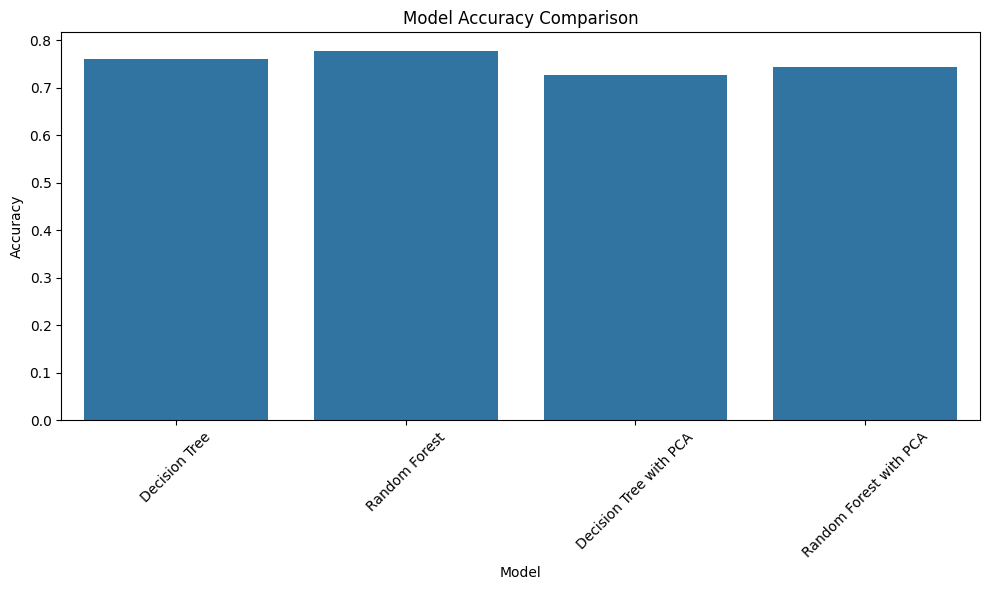


Model Performance Summary:
                    Model  Accuracy
1           Random Forest  0.777778
0           Decision Tree  0.760684
3  Random Forest with PCA  0.743590
2  Decision Tree with PCA  0.726496


In [20]:
results_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Decision Tree with PCA', 'Random Forest with PCA'],
    'Accuracy': [dt_accuracy, rf_accuracy, dt_pca_accuracy, rf_pca_accuracy]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nModel Performance Summary:")
print(results_df.sort_values('Accuracy', ascending=False))

In [22]:
best_run = mlflow.search_runs(
    experiment_names=[experiment_name],
    order_by=["metrics.accuracy DESC"]
).iloc[0]

print("Best Model Performance:")
print(f"Run ID: {best_run['run_id']}")
print(f"Model: {best_run['tags.mlflow.runName']}")
print(f"Accuracy: {best_run['metrics.accuracy']:.4f}")
print("\nParameters used:")
params = {k.replace('params.', ''): v for k, v in best_run.items() if k.startswith('params.')}
for param, value in params.items():
    print(f"{param}: {value}")

Best Model Performance:
Run ID: d0144859ff264d74abd8e7be0f29fcf3
Model: random_forest_20241207_165633
Accuracy: 0.7778

Parameters used:
min_samples_leaf: 1
n_estimators: 128
min_samples_split: 18
max_depth: 3
n_components: None
explained_variance_ratio: None


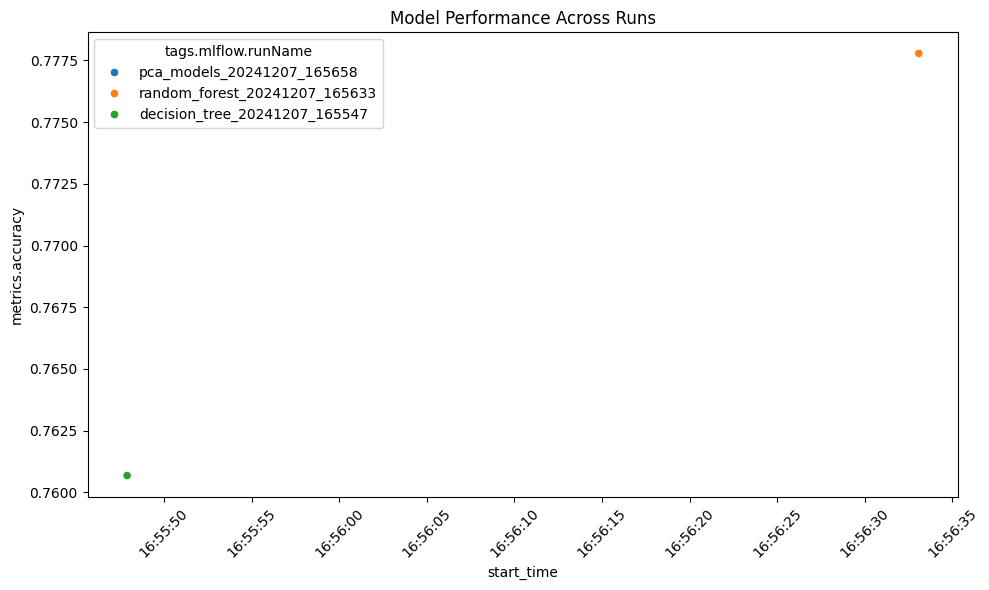


Model Performance Summary:
                               Accuracy          
                                   mean std count
Model                                            
decision_tree_20241207_165547  0.760684 NaN     1
pca_models_20241207_165658          NaN NaN     0
random_forest_20241207_165633  0.777778 NaN     1


In [23]:
all_runs = mlflow.search_runs(experiment_names=[experiment_name])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_runs, x='start_time', y='metrics.accuracy', hue='tags.mlflow.runName')
plt.xticks(rotation=45)
plt.title('Model Performance Across Runs')
plt.tight_layout()
plt.show()

summary_df = pd.DataFrame({
    'Model': all_runs['tags.mlflow.runName'],
    'Accuracy': all_runs['metrics.accuracy']
}).groupby('Model').agg(['mean', 'std', 'count'])

print("\nModel Performance Summary:")
print(summary_df)